TEXT MODEL

In [ ]:
!pip install nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Word2Vec model already exists.
Dataset columns: Index(['sentence', 'sentiment'], dtype='object')
                                            sentence sentiment
0  Protecting biodiversity is crucial for maintai...  positive
1  Deforestation and habitat destruction threaten...  negative
2  Conservation efforts should prioritize endange...  positive
3  Climate change exacerbates existing threats to...  negative
4  National parks and protected areas play a vita...  positive
Encoded dataset:
                                            sentence  sentiment
0  Protecting biodiversity is crucial for maintai...          2
1  Deforestation and habitat destruction threaten...          0
2  Conservation efforts should prioritize endange...          2
3  Climate change exacerbates existing threats to...          0
4  National parks and protected areas pla

<ipython-input-31-d0889982b67a>:248: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/Model/Text_best_model.pt"))
/usr

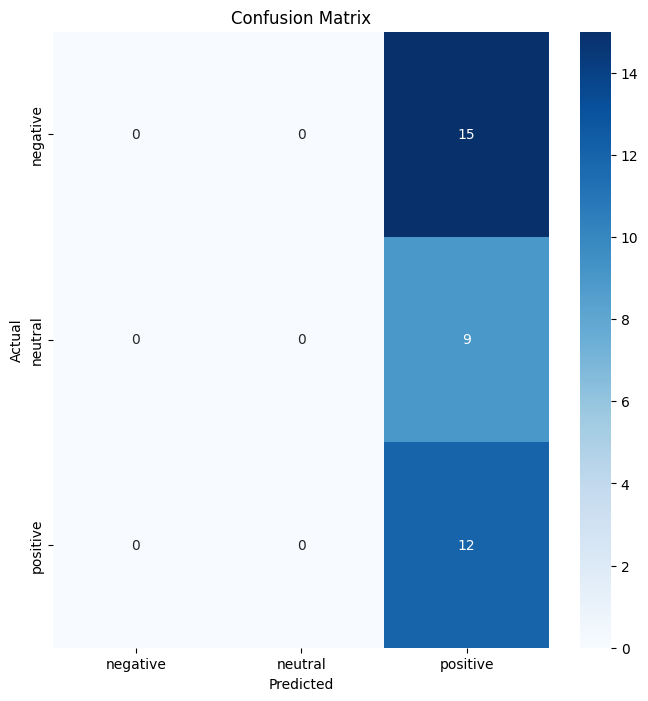

Final model saved at /content/drive/My Drive/Model/TextClassifier_Final.pt


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk import download

# Ensure necessary NLTK data is downloaded
download('punkt')

# Check for GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

# Constants
LR = 0.001
BATCH_SIZE = 32  # Reduced batch size to prevent memory issues
NUM_CLASSES = 3  # Example: negative, neutral, positive
EPOCHS = 10
HIDDEN_SIZE = 50
SEQUENCE_LENGTH = 100
VECTOR_SIZE = 300  # Embedding dimension
WINDOW = 5         # Context window size
MIN_COUNT = 1      # Minimum word frequency
WORKERS = 4        # Number of threads

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
MODEL_PATH = '/content/drive/My Drive/Model/word2vec.model'
DATA_PATH = '/content/drive/My Drive/Dataset/images_text3.csv'

# Train Word2Vec model if not already saved
if not os.path.exists(MODEL_PATH):
    print("Training Word2Vec model...")
    sentences = [word_tokenize("This is a sample sentence for Word2Vec training.")]
    w2v_model = Word2Vec(
        sentences=sentences,
        vector_size=VECTOR_SIZE,
        window=WINDOW,
        min_count=MIN_COUNT,
        workers=WORKERS
    )
    w2v_model.save(MODEL_PATH)
    print(f"Word2Vec model saved to {MODEL_PATH}")
else:
    print("Word2Vec model already exists.")

# Load dataset
df = pd.read_csv(DATA_PATH)

# Verify dataset structure
print("Dataset columns:", df.columns)
print(df.head())

# Define text and label columns
sentence = 'sentence'  # Adjust column name based on your dataset
sentiment = 'sentiment'  # Adjust column name based on your dataset

# Add dummy labels if necessary
if sentiment not in df.columns:
    print(f"'{sentiment}' column not found. Adding a dummy column for testing.")
    df[sentiment] = np.random.randint(0, NUM_CLASSES, size=len(df))

# Ensure the required columns exist
if sentence not in df.columns or sentiment not in df.columns:
    raise ValueError(f"Columns '{sentence}' or '{sentiment}' not found in dataset.")

# Load pre-trained Word2Vec model
w2v_model = Word2Vec.load(MODEL_PATH)
EMBEDDING_MATRIX = w2v_model.wv.vectors
VOCAB_SIZE, EMBEDDING_SIZE = EMBEDDING_MATRIX.shape

# Define LSTM-based TextClassifier
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        vocab_size, embedding_dim = EMBEDDING_MATRIX.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(EMBEDDING_MATRIX), freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_dim, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(HIDDEN_SIZE * 2, NUM_CLASSES)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output, _ = self.lstm(embedded)
        last_hidden_state = torch.cat((output[:, -1, :HIDDEN_SIZE], output[:, 0, HIDDEN_SIZE:]), dim=1)
        logits = self.fc(last_hidden_state)
        return logits

# Ensure the 'sentiment' column is encoded numerically
LABEL_MAPPING = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(LABEL_MAPPING)

# Check for unmapped labels
if df['sentiment'].isnull().any():
    raise ValueError("Some labels could not be mapped. Please check your dataset.")


print("Encoded dataset:")
print(df.head())


# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, dataframe, sentence, sentiment, word2vec_model):
        self.data = dataframe[sentence].tolist()
        self.labels = dataframe[sentiment].tolist()
        self.word2vec_model = word2vec_model
        self.max_sequence_length = SEQUENCE_LENGTH

    def __getitem__(self, index):
        sequence = self.data[index]
        label = self.labels[index]

        # Tokenize the sentence
        tokens = word_tokenize(sequence)

        # Convert tokens to indices based on Word2Vec vocabulary
        sequence_indices = [
            self.word2vec_model.wv.key_to_index[word] for word in tokens if word in self.word2vec_model.wv
        ]

        # Pad or truncate the sequence to the fixed length
        padded_sequence = (
            sequence_indices[:self.max_sequence_length]
            + [0] * (self.max_sequence_length - len(sequence_indices))
        )[:self.max_sequence_length]

        # Convert to tensors
        padded_sequence = torch.tensor(padded_sequence, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)  # Fixed to work with numeric labels

        return padded_sequence, label

    def __len__(self):
        return len(self.data)

# Prepare DataLoaders
data = TextDataset(df, sentence, sentiment, w2v_model)
indices = np.arange(len(data))

# Split data into train and test sets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, loss function, and optimizer
model = TextClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for batch in train_loader:
        # Unpack batch
        text, label = batch
        text, label = text.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(text)

        # Compute loss
        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        running_loss += loss.item()
        _, preds = torch.max(output, dim=1)
        running_acc += (preds == label).sum().item() / len(label)

    return running_loss / len(train_loader), running_acc / len(train_loader)


# Validation function
def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Unpack batch
            text, label = batch
            text, label = text.to(device), label.to(device)

            # Forward pass
            output = model(text)

            # Compute loss
            loss = criterion(output, label)
            running_loss += loss.item()

            # Get predictions
            _, preds = torch.max(output, dim=1)
            running_acc += (preds == label).sum().item() / len(label)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    return running_loss / len(test_loader), running_acc / len(test_loader), predictions, true_labels

# Training loop
best_val_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, _, _ = val(model, test_loader, criterion, DEVICE)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        print("New best model! Saving...")
        torch.save(model.state_dict(), "/content/drive/My Drive/Model/Text_best_model.pt")
        best_val_acc = val_acc

# Final model evaluation
model.load_state_dict(torch.load("/content/drive/My Drive/Model/Text_best_model.pt"))
_, test_acc, predictions, true_labels = val(model, test_loader, criterion, DEVICE)

print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}  # Update as needed
true_labels_mapped = [label_mapping[label] for label in true_labels]
predictions_mapped = [label_mapping[pred] for pred in predictions]

print("Classification Report:")
print(classification_report(true_labels_mapped, predictions_mapped))

# Confusion matrix
cm = confusion_matrix(true_labels_mapped, predictions_mapped, labels=list(label_mapping.values()))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Saving final model
FINAL_MODEL_PATH = "/content/drive/My Drive/Model/TextClassifier_Final.pt"
torch.save(model.state_dict(), FINAL_MODEL_PATH)
print(f"Final model saved at {FINAL_MODEL_PATH}")

# Example inference function
def predict_text(text, model, w2v_model, label_mapping, device):
    model.eval()
    tokens = word_tokenize(text)
    sequence_indices = [
        w2v_model.wv.key_to_index[word] for word in tokens if word in w2v_model.wv
    ]
    padded_sequence = torch.tensor(sequence_indices + [0] * (SEQUENCE_LENGTH - len(sequence_indices)))[:SEQUENCE_LENGTH]
    padded_sequence = padded_sequence.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(padded_sequence)
        _, predicted_label = torch.max(output, dim=1)
    return label_mapping[predicted_label.item()]

In [ ]:
# Example usage of the inference function
sample_text = "Climate change exacerbates existing threats to biodiversity and ecosystem stability."
predicted_class = predict_text(sample_text, model, w2v_model, label_mapping, DEVICE)
print(f"Predicted class for the text: {predicted_class}")

Predicted class for the text: positive


# **Below models have to be fixed**

IMAGE MODEL

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchviz import make_dot
import pydot

In [ ]:
IMG_SHAPE = 48
NUM_CLASSES = 3
BATCH_SIZE = 1024
TEXT_COL = "text_emo"
IMAGE_COL = 'local_path'
LABEL_COL = 'label'
LABELS_PATH = "C:/Users/MourtadaHouari/Desktop/sentiment-analysis/data/processed/train_images.csv"
IMAGES_PATH_PREFIX = "C:/Users/MourtadaHouari/Desktop/sentiment-analysis/data/processed"
LR = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.get_device_name(0)
SAVE_DIR = "."
EPOCHS=3

In [ ]:
dic = {0: "negative", 1: "neutral", 2: "positive"}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        acc = accuracy(output, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)

def predict(model, image, label=None):
    model.eval()
    with torch.no_grad():
        image = image.to(DEVICE)
        output = model(image)
        result = torch.max(output, dim=1).indices[0].cpu().item()
        print("predicted label:", dic[result])
        if label != None:
            print("actual label:", label)
    return output

def test(model, predict_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(predict_loader):
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

            _, preds = torch.max(output, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = running_loss / len(predict_loader)
    avg_acc = running_acc / len(predict_loader)

    return avg_loss, avg_acc, predictions, true_labels


def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(test_loader), running_acc / len(test_loader)

def save_model(model, save_dir, filename):
    torch.save(model.state_dict(), os.path.join(save_dir, filename))

In [ ]:

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # Increase filter size to 5x5
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)  # Increase filter size to 5x5
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # Keep the filter size at 3x3
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Keep the filter size at 3x3
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * IMG_SHAPE//16 * IMG_SHAPE//16, 512)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.loc[idx, IMAGE_COL][1:]
        image = Image.open(IMAGES_PATH_PREFIX+image_path).convert('RGB')
        image = self.transform(image)

        label = self.data.loc[idx, LABEL_COL]
        return image, label

In [ ]:
data = ImageDataset(LABELS_PATH)
indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model = ImageClassifier().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

In [ ]:
best_val_acc = 0.0
count = 0
val_acc_list = []
train_acc_list = []
val_loss_list = []
train_loss_list = []

EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = val(model, test_loader, criterion, DEVICE)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(
        f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


    if val_acc > best_val_acc:
        print(f"New best model! Saving...")
        save_model(model, SAVE_DIR, "attention_best_model.pt")
        best_val_acc = val_acc
        print(f"Best val acc: {best_val_acc:.4f}")
        count = 0
    else:
        count += 1
        print(f"Count: {count} of epochs have no improvement")
        if count == 5:
            print(f"Early stopping, best val acc: {best_val_acc:.4f}")
            break

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# summarize history for accuracy
axis1.plot(train_acc_list, label='Train', linewidth=3)
axis1.plot(val_acc_list, label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(train_loss_list, label='Train', linewidth=3)
axis2.plot(val_loss_list, label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
import cv2
import torch

# Initialize the camera
camera = cv2.VideoCapture(0)

while True:
    # Read the current frame from the camera
    ret, frame = camera.read()

    # Display the frame
    cv2.imshow("Camera", frame)

    # Check if the 'c' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('c'):
        # Save the current frame as an image
        cv2.imwrite("captured_image.jpg", frame)
        print("Image captured!")

        image = Image.open("captured_image.jpg").convert('RGB')
        image = transform(image).unsqueeze(0)
        text = "its fucked"

        predict(model, image, "")



    # Check if the 'q' key is pressed to exit the loopq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
camera.release()
cv2.destroyAllWindows()

In [ ]:
test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, DEVICE)

print(f"Test Acc: {test_acc:.4f}")

true_labels = [dic[i] for i in true_labels]
predictions = [dic[i] for i in predictions]

print(classification_report(true_labels,predictions))
cm = confusion_matrix(true_labels,predictions)
p = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues" )
plt.title('The Confusion Martrix of Image model')

MULTI-MODAL MODEL

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torchvision.transforms as transforms

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from torchviz import make_dot

In [ ]:
# common vars
LABEL_COL = 'label'
CSV_DATA = "images_text.csv"
NUM_CLASSES = 3
LR = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS=20
BATCH_SIZE = 2024
DF = pd.read_csv(CSV_DATA)


# image vars
IMG_SHAPE = 48
IMAGE_COL = 'local_path'

# text vars
TEXT_COL = "text_emo"
W2V_MODEL = Word2Vec.load("word2vec.model")
EMBEDDING_MATRIX = W2V_MODEL.wv.vectors
SEQUECE_LENGTH = 100
LSTM_HIDDEN_SIZE = 50
VOCAB_SIZE, EMBEDDING_SIZE = W2V_MODEL.wv.vectors.shape
HIDDEN_SIZE = 50

In [ ]:

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * IMG_SHAPE//16 * IMG_SHAPE//16, 512)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # self.fc2 = nn.Linear(512, 3)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        # x = self.fc2(x)
        # x = self.softmax(x)
        return x

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        vocab_size, embedding_dim = EMBEDDING_MATRIX.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(EMBEDDING_MATRIX), freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.lstm1 = nn.LSTM(embedding_dim, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(HIDDEN_SIZE * 2, NUM_CLASSES) # *2bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output1, _ = self.lstm1(embedded)
        last_hidden_state = torch.cat((output1[:, -1, :HIDDEN_SIZE], output1[:, 0, HIDDEN_SIZE:]), dim=1) # output1[:, -1, :]
        # logits = self.fc(last_hidden_state)
        return last_hidden_state

In [ ]:

# class MultimodalClassifier(nn.Module):
#     def __init__(self, text_model, image_model):
#         super(MultimodalClassifier, self).__init__()
#         self.text_model = text_model
#         self.image_model = image_model
#         self.attention_text = nn.Linear(NUM_CLASSES, NUM_CLASSES)
#         self.attention_image = nn.Linear(NUM_CLASSES, NUM_CLASSES)
#         self.fc = nn.Linear(NUM_CLASSES * 2, NUM_CLASSES)

#     def forward(self, text, image):
#         text_out = self.text_model(text)
#         image_out = self.image_model(image)

#         # Calculate attention weights for text and image features
#         attention_text_weights = torch.softmax(self.attention_text(text_out), dim=1)
#         attention_image_weights = torch.softmax(self.attention_image(image_out), dim=1)

#         # Apply attention weights to the text and image features
#         attended_text = attention_text_weights * text_out
#         attended_image = attention_image_weights * image_out

#         # Concatenate the attended features
#         fusion = torch.cat((attended_text, attended_image), dim=1)

#         out = self.fc(fusion)
#         return out
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_model):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.attention_weights = nn.Parameter(torch.Tensor(1, 1, 2))
        self.fc = nn.Linear(HIDDEN_SIZE * 2 + 256, NUM_CLASSES)

    def forward(self, text_input, image_input):
        # Extract text features
        text_features = self.text_model(text_input)  # Shape: [batch_size, HIDDEN_SIZE * 2]

        # Extract image features
        image_features = self.image_model(image_input)  # Shape: [batch_size, 256]

        # Apply attention to text features
        attention_scores = torch.matmul(text_features.unsqueeze(2), self.attention_weights)  # Shape: [batch_size, HIDDEN_SIZE * 2, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2, 1]
        attended_text_features = (text_features * attention_weights.squeeze(2)).sum(dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2]

        # Concatenate text features and image features
        multimodal_features = torch.cat((attended_text_features, image_features), dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2 + 256]

        # Classify the multimodal features
        logits = self.fc(multimodal_features)  # Shape: [batch_size, NUM_CLASSES]
        return logits

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_model):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc = nn.Linear(NUM_CLASSES * 2, NUM_CLASSES)

    def forward(self, text, image):
        text_out = self.text_model(text)
        image_out = self.image_model(image)

        # Element-wise multiplication of text and image features
        fusion = text_out * image_out

        # Flatten the fusion tensor
        fusion = fusion.view(fusion.size(0), -1)

        out = self.fc(fusion)
        return out

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, word2vec_model):
        self.transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])
        self.dataframe = dataframe
        self.word2vec_model = word2vec_model
        self.preprocessed_sequences = self._preprocess_text()

    def _preprocess_text(self):
        preprocessed_sequences = []
        for idx in range(len(self.dataframe)):
            text = self.dataframe.loc[idx, TEXT_COL]
            tokens = word_tokenize(text)
            sequence_indices = [self.word2vec_model.wv.key_to_index[word] for word in tokens if word in self.word2vec_model.wv]
            padded_sequence = torch.tensor(sequence_indices + [0] * (SEQUECE_LENGTH - len(sequence_indices)))[:SEQUECE_LENGTH]
            preprocessed_sequences.append(padded_sequence)
        return preprocessed_sequences

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.loc[idx, IMAGE_COL]
        label = self.dataframe.loc[idx, LABEL_COL]

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        preprocessed_sequence = self.preprocessed_sequences[idx]

        return preprocessed_sequence, image, label

In [ ]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (text, image, label) in enumerate(train_loader):
        text, image, label = text.to(device), image.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(text, image)
        loss = criterion(output, label)
        acc = accuracy(output, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)


def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for batch_idx, (text, image, label) in enumerate(test_loader):
            text, image, label = text.to(device), image.to(device), label.to(device)

            output = model(text, image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(test_loader), running_acc / len(test_loader)


def save_model(model, save_dir, filename):
    torch.save(model.state_dict(), os.path.join(save_dir, filename))


def test(model, predict_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (text, image, label) in enumerate(predict_loader):
            text, image, label = text.to(device), image.to(device), label.to(device)

            output = model(text, image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

            _, preds = torch.max(output, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = running_loss / len(predict_loader)
    avg_acc = running_acc / len(predict_loader)

    return avg_loss, avg_acc, predictions, true_labels

dic = {0: "negative", 1: "neutral", 2: "positive"}

def predict(model, text, image, label=None, eval=True):

    model.eval()

    # text processissng
    max_sequence_length = SEQUECE_LENGTH
    sequence = text
    label = label
    tokens = word_tokenize(sequence)
    sequence_indices = [W2V_MODEL.wv.key_to_index[word] for word in tokens if word in W2V_MODEL.wv]
    padded_sequence = torch.tensor(sequence_indices + [0] * (max_sequence_length - len(sequence_indices)))[:max_sequence_length].unsqueeze(0)

    with torch.no_grad():
        image = image.to(DEVICE)
        text = padded_sequence.to(DEVICE)


        output = model(text, image)
        result = torch.max(output, dim=1).indices[0].cpu().item()
        print("predicted label:", dic[result])
        if label != None:
            print("actual label:", label)
    return output

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


import multiprocessing as mp
data = MultimodalDataset(DF, W2V_MODEL)

indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

BATCH_SIZE = 10

# create data loaders for train and test sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)



text_model = TextClassifier().to(DEVICE)
image_model = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(text_model, image_model).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

preprocessed_sequence, image, label = next(iter(train_loader))
output = model(preprocessed_sequence.to(DEVICE), image.to(DEVICE))

make_dot(output)

In [ ]:
import multiprocessing as mp
data = MultimodalDataset(DF, W2V_MODEL)

indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

BATCH_SIZE = 2048

# create data loaders for train and test sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)



text_model = TextClassifier().to(DEVICE)
image_model = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(text_model, image_model).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

In [ ]:
%%time
best_val_acc = 0.0
count = 0
val_acc_list = []
train_acc_list = []
val_loss_list = []
train_loss_list = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = val(model, test_loader, criterion, DEVICE)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(
        f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


    if val_acc > best_val_acc:
        print(f"New best model! Saving...")
        save_model(model, "", "ATTENTION_FUSION_MULTI_MODEL_BEST_MODEL.pt")
        best_val_acc = val_acc
        print(f"Best val acc: {best_val_acc:.4f}")
        count = 0
    else:
        count += 1
        print(f"Count: {count} of epochs have no improvement")
        if count == 5:
            print(f"Early stopping, best val acc: {best_val_acc:.4f}")
            break

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# summarize history for accuracy
axis1.plot(train_acc_list, label='Train', linewidth=3)
axis1.plot(val_acc_list, label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(train_loss_list, label='Train', linewidth=3)
axis2.plot(val_loss_list, label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, DEVICE)

print(f"Test Acc: {test_acc:.4f}")

true_labels = [dic[i] for i in true_labels]
predictions = [dic[i] for i in predictions]

print(classification_report(true_labels,predictions))
cm = confusion_matrix(true_labels,predictions, labels=["negative", "neutral", "positive"])
p = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('The Confusion Martrix of Text model')

In [ ]:
textmodel = TextClassifier().to(DEVICE)
imagemodel = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(textmodel, imagemodel).to(DEVICE)

model.load_state_dict(torch.load("ATTENTION_FUSION_MULTI_MODEL_BEST_MODEL.pt"))

transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

image = Image.open("./train_images/t4sa/782694539618349056.jpg").convert('RGB')
image = transform(image).unsqueeze(0)
text = "hhhh"

predict(model, text, image, "positive", False)

In [ ]:
import cv2
import torch

# Initialize the camera
camera = cv2.VideoCapture(0)

while True:
    # Read the current frame from the camera
    ret, frame = camera.read()

    # Display the frame
    cv2.imshow("Camera", frame)

    # Check if the 'c' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('c'):
        # Save the current frame as an image
        cv2.imwrite("captured_image.jpg", frame)
        print("Image captured!")

        image = Image.open("captured_image.jpg").convert('RGB')
        image = transform(image).unsqueeze(0)
        text = "its fucked"

        predict(model, text, image, "positive", False)



    # Check if the 'q' key is pressed to exit the loopq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
camera.release()
cv2.destroyAllWindows()